# GAM Model for Time-Series Forecasting
## Description
This case study attempts to investigate the usage of Generalized Additive Model (GAM) on Wastewater dataset from Sandomierz, evaluate it's performance and compare it to another popular time-series forecasting model.

Models used are:
- GAM from [pygam](https://pygam.readthedocs.io/en/latest/) library
- Prophet from [Facebook](https://facebook.github.io/prophet/)

Other libraries used are:
- pandas
- numpy
- matplotlib
- statsmodels
- scikit-learn

It was done for Data Mining course led by [Ph.D Monika Chuchro](https://home.agh.edu.pl/~geoinf/en/staff/staff-members/ph-d-monika-chuchro/) on final year of Data Engineering and Analysis course on [AGH UST](https://www.agh.edu.pl/en).

## Load data
First let's load our data and see the first few rows.

In [1]:
import pandas as pd

df = pd.read_csv("../data/wastewater.txt", sep="\s+", names=["Date", "Sandomierz"], skiprows=1)
df.head()

,Date,Sandomierz
0,2002.01,3.216
1,2002.02,2.803
2,2002.03,2.887
3,2002.04,NaN
4,2002.05,2.983


Our dataset is a time series with a single column. Right off the bat we can see we'll deal with some missing values. Let's check how many rows we have.

In [2]:
df.shape

(66, 2)

Now let's check our datatypes.

In [3]:
df.dtypes

Date          float64
Sandomierz    float64
dtype: object

We can see that our date column inferred `float` type. Let's fix that by casting it to `datetime`.

In [4]:
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y.%m")
df.head()

,Date,Sandomierz
0,2002-01-01,3.216
1,2002-02-01,2.803
2,2002-03-01,2.887
3,2002-04-01,NaN
4,2002-05-01,2.983


In [5]:
df = df.set_index("Date")
df = df.sort_index()

Finally let's check for missing values.

In [6]:
df.isna().sum()

Sandomierz    1
dtype: int64

There is only one missing value so we will interpolate it.

In [311]:
df["Sandomierz"] = df["Sandomierz"].interpolate()

## Exploratory Data Analysis
Now let's perform Exploratory Data Analysis to see how our data looks.

Let's start by doing a simple plot.

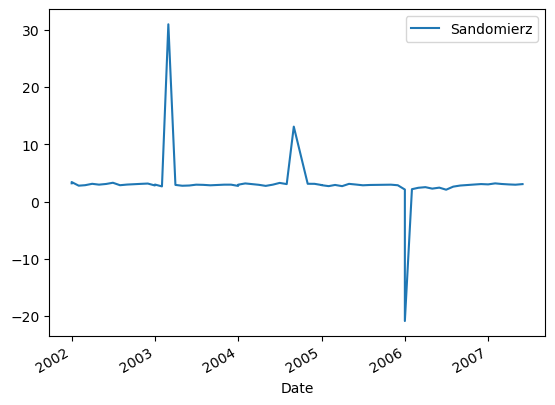

In [312]:
import matplotlib.pyplot as plt

df.plot()
plt.show()

There seem's to be 3 outliers in our dataset, we will deal with it later.

Let's also see how our values are distributed on a histogram.

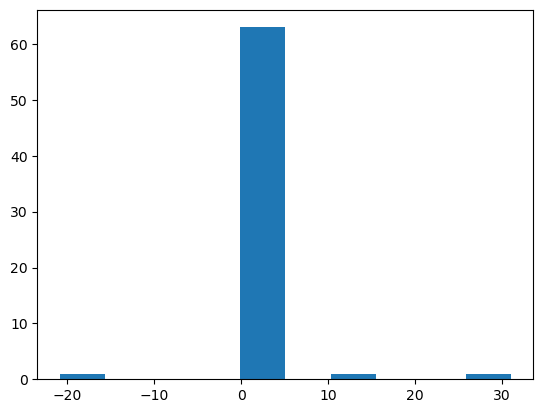

In [313]:
plt.hist(df["Sandomierz"])
plt.show()

We can clearly see that we have 3 outliers, so let's remove them.

In [129]:
df_cleaned = df.copy()

mean_value = df_cleaned['Sandomierz'].mean()
z_scores = (df_cleaned['Sandomierz'] - mean_value) / df_cleaned['Sandomierz'].std()

outliers = z_scores.abs() > 1
df_cleaned.loc[outliers, 'Sandomierz'] = np.nan

In [131]:
df_cleaned["Sandomierz"] = df_cleaned["Sandomierz"].interpolate()

Now let's plot our cleaned data.

<Axes: xlabel='Date'>

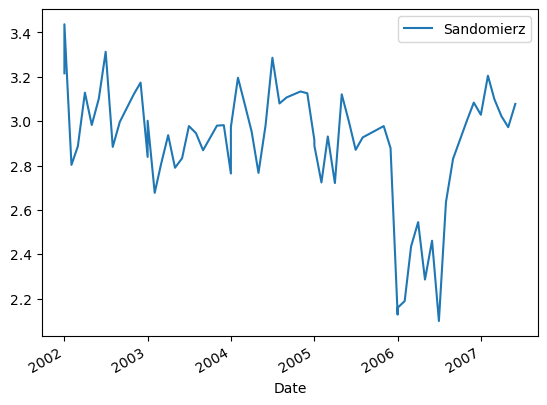

In [132]:
df_cleaned.plot()
plt.show()

This time-series looks much better and is something we can work with. We can see that around the year 2006 there is a significant drop. Let's also check our histogram.

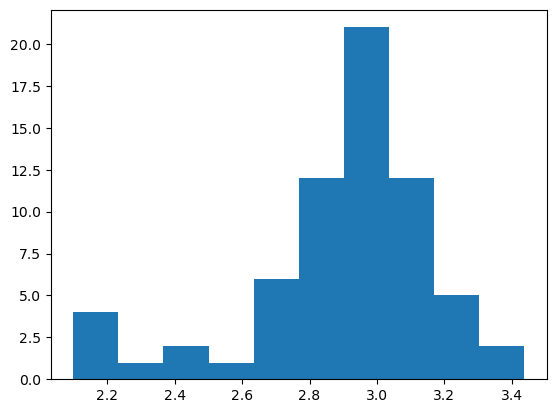

In [133]:
plt.hist(df_cleaned["Sandomierz"])
plt.show()

We can clearly see the lower values on the left side which correspond to our "dent" on line plot. What's interesting is that apart from these lower values our data seems to be normally distributed.

## Time-Series Analysis

To analyze our data better we will plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PCF)

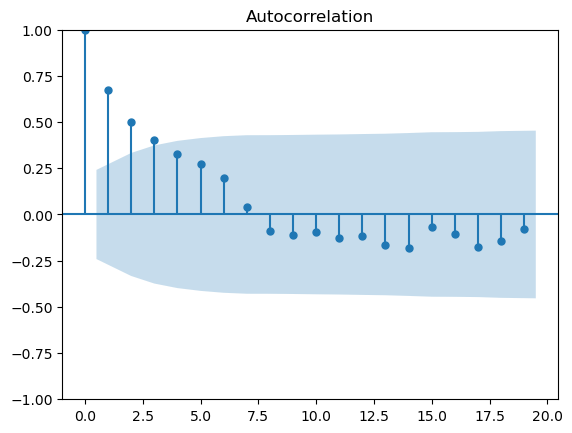

In [134]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_cleaned["Sandomierz"])
plt.show()

The ACF plot shows a gradual decline indication that our data is non-stationary.

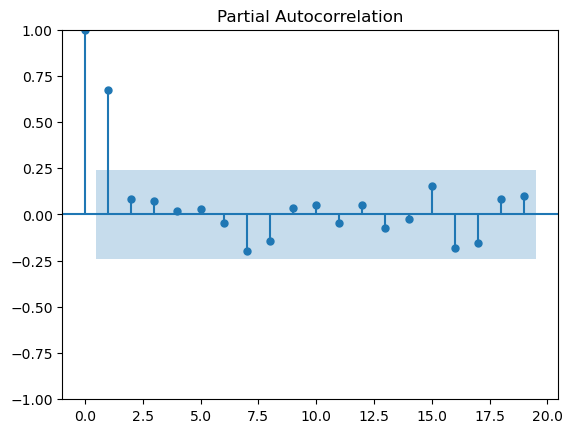

In [135]:
plot_pacf(df_cleaned["Sandomierz"])
plt.show()

Our PACF plot has a significant spike at the beginnig, which suggests an autoregressive term of order 1.

Additionally let's perform a decomposition to see the trend, seasonality and residuals.

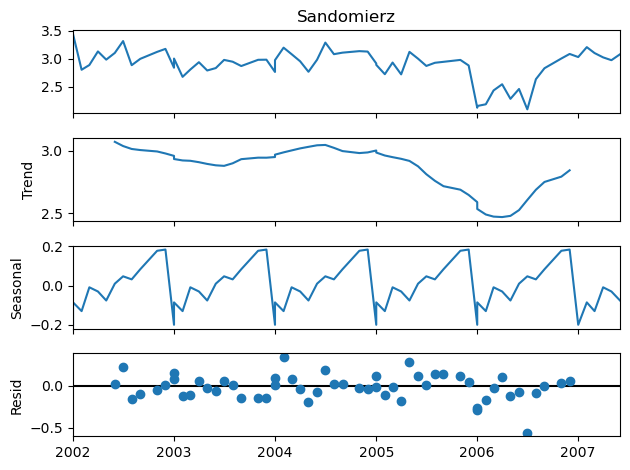

In [136]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_cleaned["Sandomierz"], model="additive", period=12)
decomposition.plot()
plt.show()

From these plots we can clearly see that our data has non-linear trend and distincitve yearly seasonality.

## GAM Model
Since the data we are working with is a time-series with a single curve and non-linear pattern first we will try to fit a Generalized Additive Model (GAM).

Because there is seasonality in our data we will definitly like to catch it with our model. To do so we will need to prepare our data a bit.

First we will add a numerical index for time

In [137]:
import numpy as np


df_gam = pd.DataFrame()
df_gam['time'] = np.arange(len(df_cleaned))

Then we need to extract month for our seasonality.

In [138]:
df_gam['month'] = df_cleaned.index.month

To capture our seasonality better we will add a cyclic term.

In [139]:
df_gam['month_sin'] = np.sin(2 * np.pi * df_gam['month'] / 12)
df_gam['month_cos'] = np.cos(2 * np.pi * df_gam['month'] / 12)

Now let's specify our GAM model. We will add a spline for each of our new seasonality features.

In [140]:
from pygam import GAM, s

gam = GAM(s(0) + s(1) + s(2))

Now to evaluate GAM model performance we will split our data to train and test sets. We will leave **80%** of data for training.

In [186]:
train_size = int(0.8 * len(df_gam))

X_train = df_gam.iloc[:train_size].values
X_test = df_gam.iloc[train_size:].values

y_train = df_cleaned.iloc[:train_size].values
y_test = df_cleaned.iloc[train_size:].values

Now let's fit our model.

In [187]:
gam.fit(X_train, y_train)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + intercept, tol=0.0001, verbose=False)

Let's calculate Mean Squared Error and Mean Absolute Error, we will interpret those value at the end.

In [308]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = gam.predict(X_test)

gam_mse = mean_squared_error(y_test, y_pred)
gam_mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {gam_mse}')
print(f'Mean Absolute Error: {gam_mae}')

Mean Squared Error: 0.0648596561538733
Mean Absolute Error: 0.1760016064534325


Let's see how our model performed on a plot

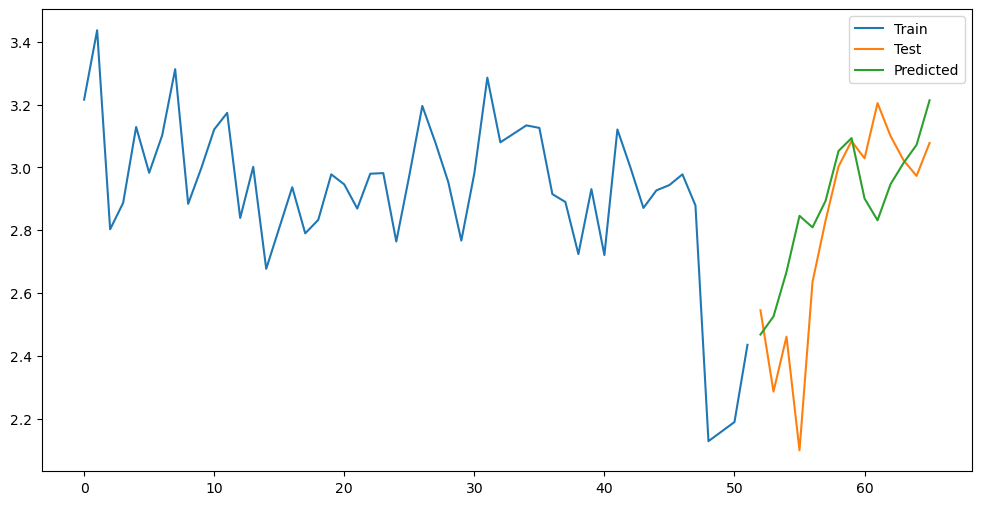

In [189]:
plt.figure(figsize=(12, 6))
plt.plot(X_train[:, 0], y_train, label="Train")
plt.plot(X_test[:, 0], y_test, label="Test")
plt.plot(X_test[:, 0], y_pred, label="Predicted")
plt.legend()
plt.show()

We could further improve our model by tuning it's parameters or performing grid search.

## Comparison
At the end we will compare our GAM model with other popular time-series model [Prophet](https://facebook.github.io/prophet/).

First we need to slighly change the format of our dataframe for Prophet model.

In [190]:
df_prophet = df_cleaned.reset_index()
df_prophet.columns = ["ds", "y"]

Now we can split it into train and test sets.

In [301]:
train_set = df_prophet.iloc[:train_size]
test_set = df_prophet.iloc[train_size:]

Here we import and create the Prophet mode. By default it models daily, weekly and yearly seasonalities. Let's turn them all off.

In [303]:
from prophet import Prophet

prophet = Prophet(
    changepoint_prior_scale=0.05,
    weekly_seasonality=False,
    daily_seasonality=False,
    yearly_seasonality=False
)

Now we add our own yearly seasonality.

In [304]:
prophet.add_seasonality(name='yearly', period=365.25, fourier_order=5)

Let's fit our model to the train set.

In [305]:
prophet.fit(train_set)

16:51:57 - cmdstanpy - INFO - Chain [1] start processing


16:51:57 - cmdstanpy - INFO - Chain [1] done processing


Here we create a future dataframe and make predicitons.

In [297]:
future = prophet.make_future_dataframe(periods=len(test_series), freq="M")

In [298]:
forecast = prophet.predict(future)

Let's evaluate our Prophet model performance by calulating MAE and MSE just like with GAM model.

In [307]:
actuals = test_series['y']
predictions = forecast['yhat'].iloc[-len(test_series):]

prophet_mse = mean_squared_error(actuals, predictions)
prophet_mae = mean_absolute_error(actuals, predictions)

print(f'Mean Squared Error: {prophet_mse}')
print(f'Mean Absolute Error: {prophet_mae}')

Mean Squared Error: 0.2706446002344495
Mean Absolute Error: 0.44526483967663505


Finally let's see how our predictions look on a plot.

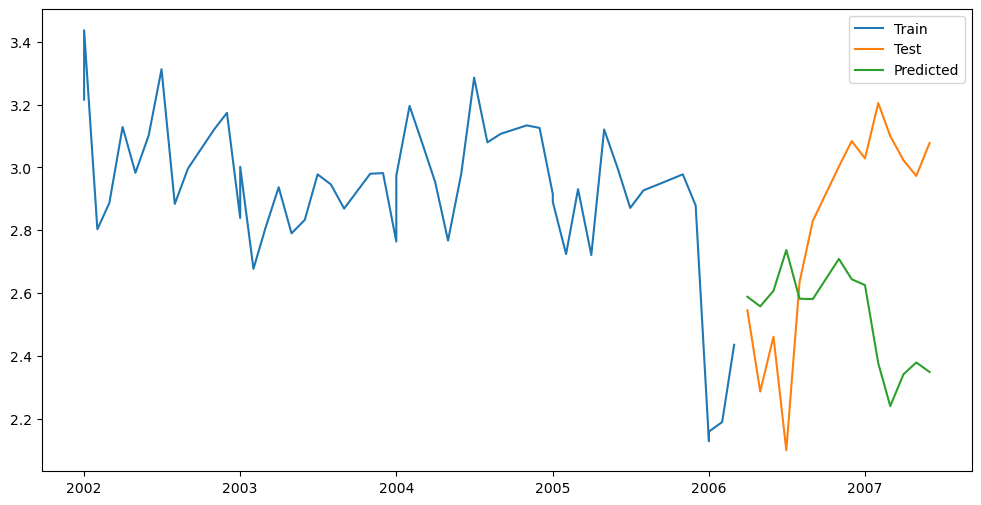

In [300]:
plt.figure(figsize=(12, 6))
plt.plot(train_series['ds'], train_series['y'], label="Train")
plt.plot(test_series['ds'], test_series['y'], label="Test")
plt.plot(test_series['ds'], predictions, label="Predicted")
plt.legend()
plt.show()

We see that Prophet fails to capture the rising trend at the end. However we didn't perform any parameter tuning or gridsearch which could improve the models performance.

## Conclusions
On our dataset with wastewater from Sandomierz the **GAM** model is a clear winner, as it greaty outperformed **Prophet** model. 

The success of the GAM model can be attributed to effective data processing and feature engineering, which allowed us to capture the underlying trend and seasonality patterns within the dataset.

However, it's important to acknowledge certain limitations of this study. We did not conduct hyperparameter tuning using grid search or evaluate the models with cross-validation. Additionally, we did not explore alternative models such as SARIMA, Exponential Smoothing or machine learning methods like Gradient Boosting, which may offer potential improvements in predictive accuracy.

In [310]:
results = pd.DataFrame(
    {"GAM": [gam_mse, gam_mae], "Prophet": [prophet_mse, prophet_mae]},
    index=["MSE", "MAE"]
)
results

,GAM,Prophet
MSE,0.064860,0.270645
MAE,0.176002,0.445265
